# Configure Notebook

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import time

import findspark
findspark.init()

from geopy.distance import geodesic

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, avg, udf, to_timestamp, date_trunc
from pyspark.sql.functions import year, month, hour, dayofweek
from pyspark.sql.functions import round, concat, col, lit
from pyspark.sql.functions import log1p

from pyspark.sql.types import FloatType, StructType, IntegerType, StringType, DoubleType, StructField, TimestampType, DateType
from pyspark.sql.types import TimestampType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression
from pyspark.ml.feature import StringIndexer, VectorIndexer, Normalizer
from pyspark.ml.evaluation import RegressionEvaluator

import random

spark1 = SparkSession.builder.appName("SingleStationRF").getOrCreate()

import datetime as dt
print("modules imported")

randomSeed = 1984

pathWeather = "/users/sajudson/Dropbox/WPI/DS504/project/weather/"
pathData = "/users/sajudson/Dropbox/WPI/DS504/project/data/"
pathFigure = "/users/sajudson/Dropbox/WPI/DS504/project/figures/"

file_type = "csv"

plt.style.use('ggplot')

modules imported


# Load Sample Station Data


In [5]:
#SELECT WHICH CITY TO USE FOR ANALYSIS 
city = "NYC"
#city = "JC"

tripSampleFraction = .20
stationSampleFraction = .20

sample = str(int(tripSampleFraction*100))


t0= time.time()

filenameBF = "citibike"+city+"bf3_sample_"+sample
filenameOutput = filenameBF+".csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

sampleStationDataFeatureSchema = StructType([StructField('datetime', TimestampType(), False),
                              StructField('station_id', IntegerType(), False),
                              StructField('totalDemand', IntegerType(), False),
                              StructField('totalSupply', IntegerType(), False)    
                              ])

# The applied options are for CSV files. For other file types, these will be ignored.
sampleStationData = spark1.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(sampleStationDataFeatureSchema) \
  .load(pathData+filenameOutput)

print(time.time()-t0)
# this operation takes ~0.27seconds

2.0328760147094727


In [6]:
# for testing and debugging only
#t0= time.time()
#sampleStationData.describe().show()
#sampleStationData.show()
#print(time.time()-t0)

# this operation takes ~3.4 seconds

# Load Weather Features Data Set


In [7]:
weatherFeatures = "NYC"+'weatherFeatures'
weather_file_type = 'csv'
weatherFilename = weatherFeatures + "."+weather_file_type

weatherFeatureSchema = StructType([StructField('temp', DoubleType(), False),
                            StructField('humidity', DoubleType(), True),
                            StructField('total_precip', DoubleType(), True),
                            StructField('cloud_cover', DoubleType(), True),                 
                            StructField('datetime', TimestampType(), True)
                           ])


# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
weatherFeatures = spark1.read.format(weather_file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(weatherFeatureSchema) \
  .load(pathWeather+weatherFilename)

# for testing and debugging only
#weatherFeatures.describe().show()

# Generate List of Stations included in Sample Station dataset

In [8]:
sampleStationList = sampleStationData.select("station_id").distinct().orderBy("station_id").rdd.map(lambda row : row[0]).collect() 

# for testing and debugging only
#print(sampleStationList)
#Expected Output 
#[3183, 3184, 3188, 3193, 3199, 3200, 3207, 3209, 3213, 3214, 3220, 3225, 3281, 3483]

In [9]:
#inspect sample station list data set

inspectStationSample = False
if inspectStationSample == True:
      
    stationRecordAverage =0
    stationRecordMax =0
    stationRecordMin =999999999
    stationRecordCount = []
    stationCount = len(sampleStationList)
    for i in  range(0,stationCount):
        s = sampleStationList[i]            
        sdf = sampleStationData.filter(sampleStationData.station_id == s) #.orderBy('datetime')
        stationRecordCount.append(sdf.count())
        stationRecordAverage = stationRecordAverage + stationRecordCount[i]/stationCount
        if stationRecordMax < stationRecordCount[i]:
            stationRecordMax =stationRecordCount[i]
        if stationRecordMin > stationRecordCount[i]:
            stationRecordMin =stationRecordCount[i]
        print("station_id =",s, "records = ", stationRecordCount[i])
        print(sdf.show(1))
    print(stationRecordAverage)
    print(stationRecordAverage/(3*8760))
    print(stationRecordMin/(3*8760))
    print(stationRecordMax/(3*8760))

# Create Station Level Data Set
- Filter based on station selected
- Merge with weather data
- Fill hours without any trip data (i.e., demand or supply is null) with zeroes
- Create date based features in station data set


In [13]:
t0 = time.time()
#select single station for initial run
station = 285 #sampleStationList[67]
print("station_id =",station)
#tripSampleFraction = 1.0
bf_station = sampleStationData.filter(sampleStationData.station_id == station)
#bf_station = bf_station.sample(False, tripSampleFraction, randomSeed)
    
print(bf_station.count())


#left join includes all intervals in weather file in output - then fill supply and demand nulls with zeroes
#right joing only includes intervals with supply or demand 
bf_station = weatherFeatures.join(bf_station, ['datetime'],how = "left")
bf_station = bf_station.fillna({'totalDemand':'0','totalSupply':'0'})

#bf_station.show()
print("rows in dataframe",bf_station.count())
print(time.time()-t0)
    
#print(sampleStationList)

# year month and hour are redundent with metblue data fields
bf_station = bf_station.withColumn("year", year(bf_station.datetime).cast("integer"))
bf_station = bf_station.withColumn("month", month(bf_station.datetime).cast("integer"))
#bf_station = bf_station.withColumn("date", date_trunc("day", bf_station.datetime))

@udf('boolean')
def ifWeekday(dow):
    if dow > 5.0: return False
    else: return (True)

bf_station = bf_station.withColumn("hourOfDay", hour(bf_station.datetime).cast('integer'))
bf_station = bf_station.withColumn("dayOfWeek", dayofweek(bf_station.datetime).cast("integer"))
bf_station = bf_station.na.drop(how="any", subset=['dayOfWeek','hourOfDay'])
bf_station = bf_station.withColumn("weekday", ifWeekday(bf_station.dayOfWeek))

#Label y
linkFunction = "log1p"
#linkFunction = "none"
if linkFunction == "log1p":
    bf_station = bf_station.withColumn("logDemand", log1p(bf_station.totalDemand))
    bf_station = bf_station.withColumn("logSupply", log1p(bf_station.totalSupply))
    
else:
    bf_station = bf_station.withColumn("label", bf_station.totalDemand)

print(time.time()-t0)

bf_station.cache()
#bf_station.show()
print(time.time()-t0) 
#bf_station.describe().show()
print(bf_station.columns)

station_id = 285
9112
rows in dataframe 26304
1.218966007232666
1.31435227394104


DataFrame[datetime: timestamp, temp: double, humidity: double, total_precip: double, cloud_cover: double, station_id: int, totalDemand: int, totalSupply: int, year: int, month: int, hourOfDay: int, dayOfWeek: int, weekday: boolean, logDemand: double, logSupply: double]

1.5719773769378662
['datetime', 'temp', 'humidity', 'total_precip', 'cloud_cover', 'station_id', 'totalDemand', 'totalSupply', 'year', 'month', 'hourOfDay', 'dayOfWeek', 'weekday', 'logDemand', 'logSupply']


0.010094165802001953


In [22]:

bfStation = bf_station.toPandas()


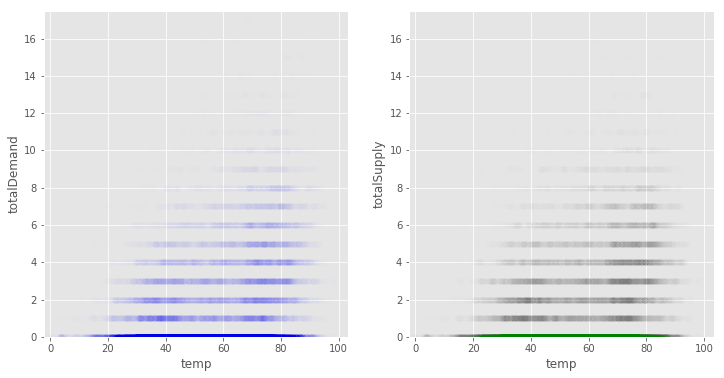

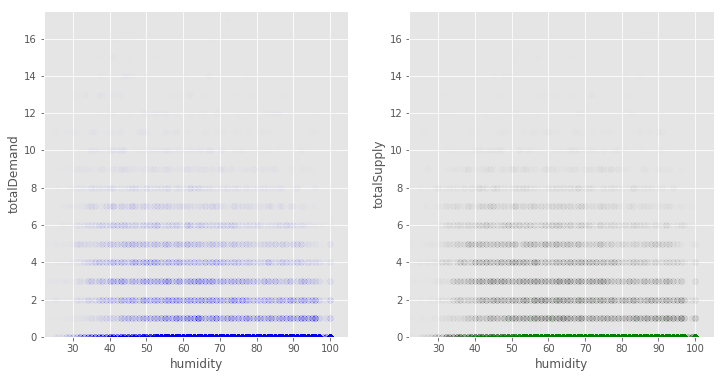

In [115]:




xlabel= ['temp', 'humidity', 'total_precip', 'cloud_cover', 
         'year', 'month', 'hourOfDay', 'dayOfWeek', 'weekday']
#xdata = [0,0,0,0,0,0,0,0,0]

ylabel= ['totalDemand','totalSupply', 'logDemand', 'logSupply']
#ydata = [0,0,0,0]

#for x in xdata:
#    xdata[x] = bf_station.select(xlabel[x]).collect()
#
#for y in ydata:
#    ydata[y] = bf_station.select(ylabel[y]).collect()


title1= "EDA"

filename="EDA_NYC_SINGLESTATION"
figurepath = pathFigure
figsaveformat = '.png'
colors = ['blue','green','red']
lw_default = 1


def stationEDAPlot(xlabel,ylabel1, ylabel2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    def ytickformat(x): 
        return '$%1.2f' % x

    def xtickformat(x): 
        return '$%1.2f' % x

    yScaleMin = 0
    yScaleMax = 17.5 #np.max(np.max(bfStation[ylabel[0]]),np.max(bfStation[ylabel[1]]))*1.05

    # plot y1
    alpha  = .005

    axes[0].plot(bfStation[xlabel],bfStation[ylabel1], color = colors[0], marker ='o', linewidth = 0,alpha = alpha)
    axes[0].set_ylabel(ylabel1)
    axes[0].set_xlim(np.min(bfStation[xlabel])*1.05-1, np.max(bfStation[xlabel]*1.05))
    axes[0].set_ylim(0, yScaleMax)
    axes[0].set_xlabel(xlabel)
    axes[0].format_xdata = xtickformat
    axes[0].format_ydata = ytickformat
    axes[0].grid(True)
  
    axes[1].plot(bfStation[xlabel],bfStation[ylabel2] ,color = colors[1], marker ='o', linewidth = 0, alpha = alpha)
    axes[1].set_ylabel(ylabel2)
    axes[1].set_xlim(np.min(bfStation[xlabel])*1.05-1, np.max(bfStation[xlabel]*1.05))
    axes[1].set_ylim(0, yScaleMax)
    axes[1].set_xlabel(xlabel)
    axes[1].format_xdata = xtickformat
    axes[1].format_ydata = ytickformat
    axes[1].grid(True)
    
    
        
    #save figure as PNG
    figfilename = figurepath+filename+xlabel+figsaveformat
    plt.savefig(figfilename, bbox_inches='tight', dpi = (300))
    
    plt.show()
    
    return

def stationEDAPlot2(xlabel,ylabel1, ylabel2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    def ytickformat(x): 
        return '$%1.2f' % x

    def xtickformat(x): 
        return '$%1.2f' % x

    yScaleMin = 0
    yScaleMax = 20 #np.max(np.max(bfStation[ylabel[0]]),np.max(bfStation[ylabel[1]]))*1.05

    # plot y1
    alpha  = .005

    axes[0].plot(bfStation[xlabel],bfStation[ylabel1], color = colors[0], marker ='o', linewidth = 0,alpha = alpha)
    axes[0].set_ylabel(ylabel1)
    axes[0].set_xlim(np.min(bfStation[xlabel])*1.05-1, np.max(bfStation[xlabel]*1.05))
    axes[0].set_ylim(0, yScaleMax)
    axes[0].set_xlabel(xlabel)
    axes[0].format_xdata = xtickformat
    axes[0].format_ydata = ytickformat
    axes[0].grid(True)
  
    axes[1].plot(bfStation[xlabel],bfStation[ylabel2] ,color = colors[1], marker ='o', linewidth = 0, alpha = alpha)
    axes[1].set_ylabel(ylabel2)
    axes[1].set_xlim(np.min(bfStation[xlabel])*1.05-1, np.max(bfStation[xlabel]*1.05))
    axes[1].set_ylim(0, yScaleMax)
    axes[1].set_xlabel(xlabel)
    axes[1].format_xdata = xtickformat
    axes[1].format_ydata = ytickformat
    axes[1].grid(True)
    
    
        
    #save figure as PNG
    figfilename = figurepath+filename+xlabel+figsaveformat
    plt.savefig(figfilename, bbox_inches='tight', dpi = (300))
    
    plt.show()
    return

stationEDAPlot(xlabel[0],ylabel[0],ylabel[1])
stationEDAPlot(xlabel[1],ylabel[0],ylabel[1])



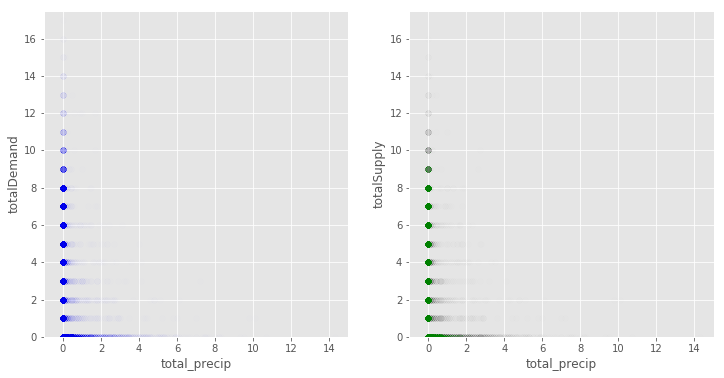

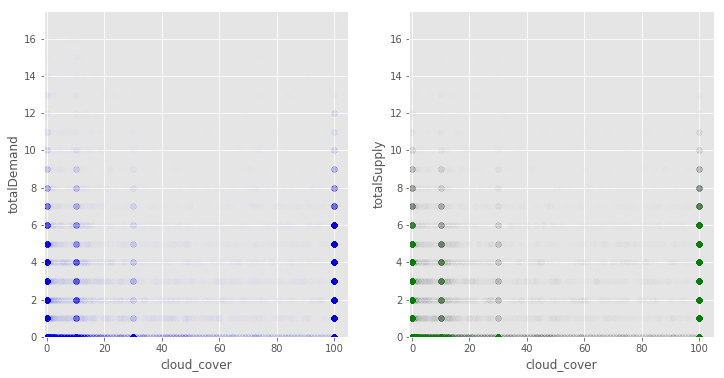

In [116]:

stationEDAPlot(xlabel[2],ylabel[0],ylabel[1])

stationEDAPlot(xlabel[3],ylabel[0],ylabel[1])


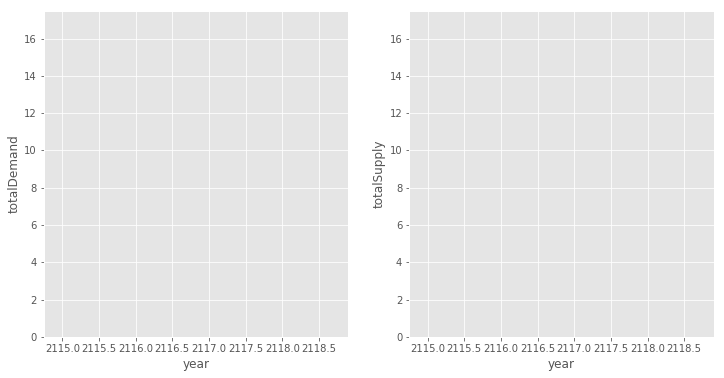

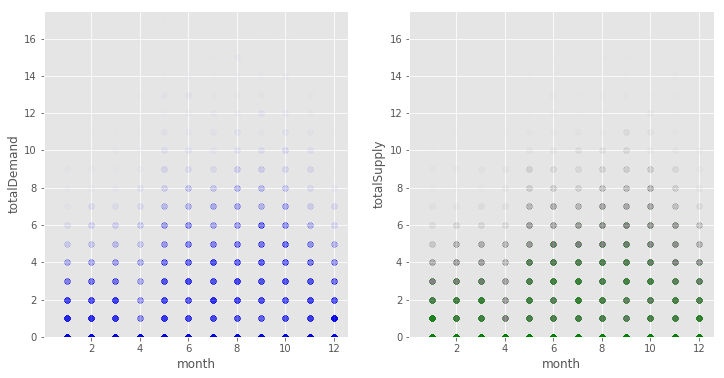

In [117]:

stationEDAPlot(xlabel[4],ylabel[0],ylabel[1])
stationEDAPlot(xlabel[5],ylabel[0],ylabel[1])


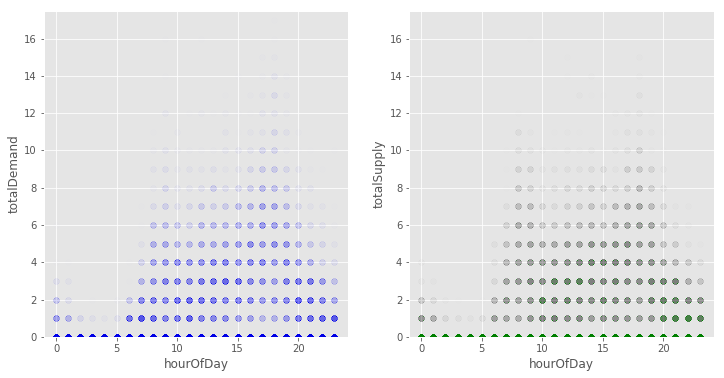

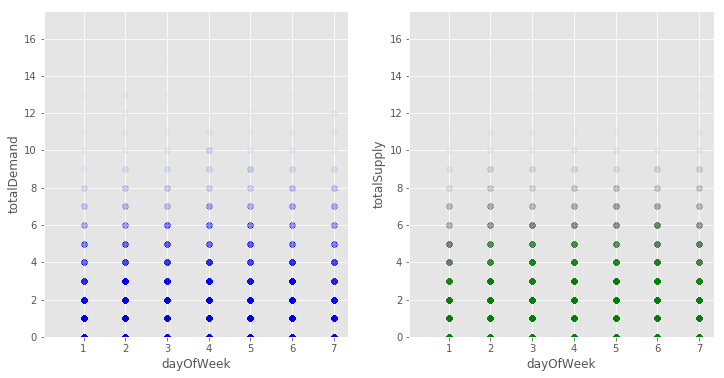

In [118]:

stationEDAPlot(xlabel[6],ylabel[0],ylabel[1])
stationEDAPlot(xlabel[7],ylabel[0],ylabel[1])


In [119]:
j = int(np.random.random() *100)
e =0
for i in range(0,j):
    e += 1

print(j,e)




84 84


In [120]:
time.time()

1541221256.1035452

In [121]:
print("="*80)